In [ ]:
!pip install -U google-cloud
!pip install -U google-cloud-bigquery

In [506]:
import sys
import pandas as pd
import datalab.bigquery as bq
import matplotlib.pyplot as plt

%matplotlib inline

In [505]:
PROJECT = 'ksalama-gcp-playground'

# New York Citibike Dataset

### Weekly Trips

In [349]:
%bq query --name data_week

WITH trips_data
AS
(
  SELECT
    CONCAT(CAST(EXTRACT(YEAR FROM starttime) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM starttime) AS STRING),2,'0')) trip_week,
    COUNT(*)/10000 trip_count
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    starttime IS NOT NULL
  AND
    starttime < '2016-07-01'
  AND
    CONCAT(CAST(EXTRACT(YEAR FROM starttime) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM starttime) AS STRING),2,'0')) >= '2013-27'
  AND
    EXTRACT(WEEK FROM starttime) != 0
  GROUP BY
    trip_week
  ORDER BY 
    trip_week ASC
)

SELECT
  trip_week,
  CASE WHEN trip_week <= '2014-06' THEN trip_count * 0.70 ELSE trip_count END trip_count
FROM
  trips_data  
;

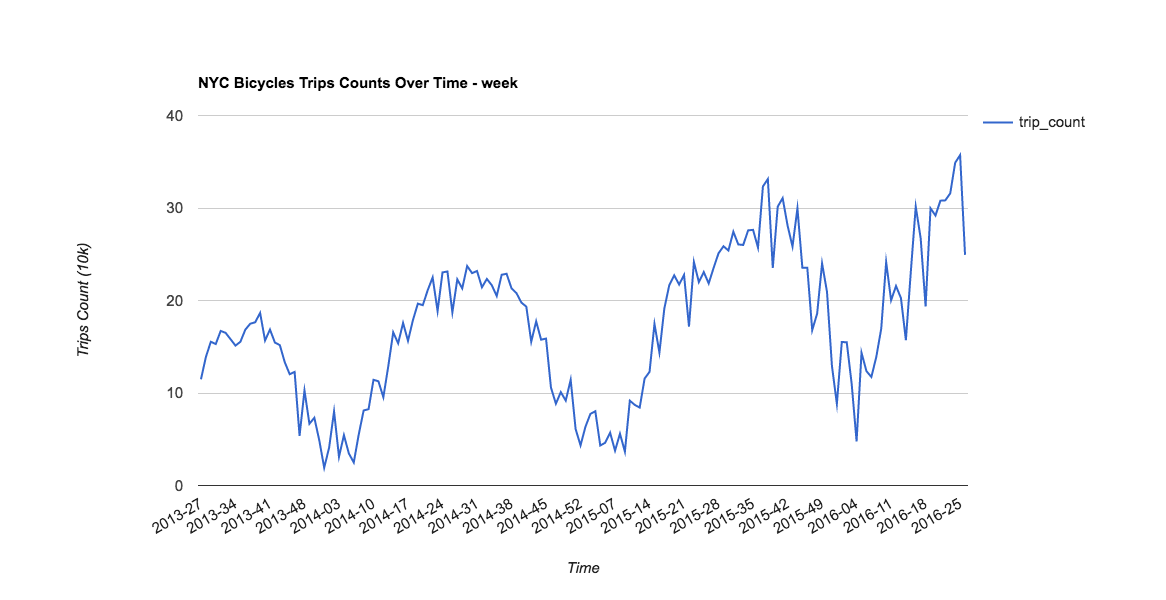

In [350]:
%chart line --data data_week --fields trip_week,trip_count
title: NYC Bicycles Trips Counts Over Time - week
height: 600
#width: 1200
hAxis:
  title: Time
vAxis:
  title: Trips Count (10k)

## Experiment:

* Granularity: Week


* Cycle: Year


* Dataset: [2013-27: 2016-26] (156 weeks: 3 cycles)


* Learning data: [2013-27: 2015-52] (130 weeks: 2.5 cycles)


    * Train data: [2013-27: 2015-26] (104 weeks: 2 cycles)

    * Eval  data: [2015-27: 2015-52] (26 weeks: 0.5 cycle)


* Test  data: [2016-01: 2016-26] (26 weeks:  0.5 cycle)

## Create BigQuery Dataset

In [161]:
!bq --location='US' mk --dataset bqml_ts

BigQuery error in mk operation: Dataset 'ksalama-gcp-playground:bqml_ts' already
exists.


## Loading the Trips Data to our Dataset

In [351]:
%bq query 

CREATE OR REPLACE TABLE bqml_ts.trips_data
AS
  SELECT 
    ROW_NUMBER() OVER(ORDER BY trip_week) time_index,
    trip_week,
    week_number,
    CASE WHEN trip_week <= '2014-06' THEN trip_count * 0.65 ELSE trip_count END value
  FROM
  (
    SELECT
      CONCAT(CAST(EXTRACT(YEAR FROM starttime) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM starttime) AS STRING),2,'0')) AS trip_week,
      EXTRACT(WEEK FROM starttime) AS week_number,
      COUNT(*)/10000 trip_count
    FROM
      `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE 
      starttime IS NOT NULL
    AND
      starttime < '2016-07-01'
    AND
      CONCAT(CAST(EXTRACT(YEAR FROM starttime) AS STRING),'-',LPAD(CAST(EXTRACT(WEEK FROM starttime) AS STRING),2,'0')) >= '2013-27'
    AND
      EXTRACT(WEEK FROM starttime) != 0
    GROUP BY
      trip_week,
      week_number
    ORDER BY 
      trip_week ASC
  )
;

time_index,trip_week,week_number,value
109,2015-31,31,27.4373
143,2016-13,13,20.2629
146,2016-16,16,30.1491
153,2016-23,23,31.5842
154,2016-24,24,34.8903
23,2013-49,49,6.196645
33,2014-07,7,5.5019
122,2015-44,44,29.9723
123,2015-45,45,23.5457
34,2014-08,8,8.1089


## A. Baseline: Simple linear regression (ignoring temporal autocorrelation)

### 1. Train the BQML model using training & evaluation data (time_index <= 130)
* data_split_method is set to 'seq'
* data_split_eval_fraction=0.2
    * Training data is 80%
    * Evaluation datat is 20%

In [ ]:
%bq query 

CREATE OR REPLACE MODEL bqml_ts.simple_model
OPTIONS
  ( 
    model_type='linear_reg', 
    input_label_cols=['value'],
    data_split_method='seq',
    data_split_col='time_index_split',
    data_split_eval_fraction=0.2
)
AS
  SELECT 
    time_index, 
    value,
    time_index AS time_index_split
  FROM bqml_ts.trips_data
  WHERE
    time_index <= 130 #Train and Eval data
  

### 2. Get predictions for training & evaluation data

In [511]:
%sql --module query1 

SELECT
  time_index,
  value,
  predicted_value
FROM
  ml.PREDICT(
    model bqml_ts.simple_model,
    (
      SELECT 
        time_index,
        value
      FROM bqml_ts.trips_data
      WHERE
        time_index <= 130 
    )
  )
ORDER BY
  time_index ASC

### 3. Plot the acutal vs. predicted for training and evaluation data

In [513]:
results1 = bq.Query(query1).to_dataframe(dialect='standard')
results1.head(5)

,time_index,value,predicted_value
0,1,10.660455,12.440533
1,2,12.901590,12.470629
2,3,14.430715,12.500725
3,4,14.201720,12.530820
4,5,15.516215,12.560916


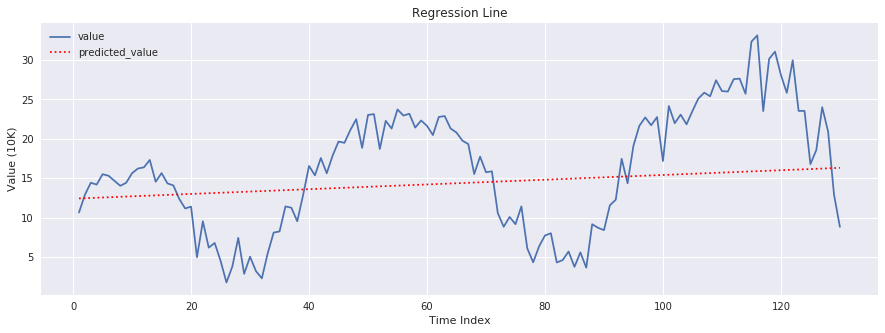

In [515]:
plt.close('all')
plt.figure(figsize=(15, 5))

plt.subplot(1,1,1)
plt.title("Regression Line")
plt.plot(results1.time_index, results1.value)
plt.plot(results1.time_index, results1.predicted_value, ':r')
plt.xlabel("Time Index")
plt.ylabel("Value (10K)")
plt.legend()
# --

### 4. Evaluate the BQML model using the test data

In [516]:
%bq query 

SELECT *
FROM ml.EVALUATE(
  model bqml_ts.simple_model,
  (
    SELECT 
      time_index,
      value
    FROM 
      bqml_ts.trips_data
    WHERE
      time_index > 130 #Test data
  )
)

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
7.5847184196,88.0979253525,0.197578597426,5.40667304584,-0.330539681313,0.0475210867504


### Result: RMSE for a simple linear regression = 9.38

## B. Time-series: Linear Regression Model with Temporal Transformation

### 1. Create a training dataset with temporal transformations
* 5 previous values
* 5 fourier transformations

In [ ]:
%bq query 

CREATE OR REPLACE TABLE bqml_ts.learn_data_engineered
AS
SELECT 

   time_index
  ,value

  ,LAG(value,1) OVER (ORDER BY time_index) AS prev_value_1
  ,LAG(value,2) OVER (ORDER BY time_index) AS prev_value_2
  ,LAG(value,3) OVER (ORDER BY time_index) AS prev_value_3
  ,LAG(value,4) OVER (ORDER BY time_index) AS prev_value_4
  ,LAG(value,5) OVER (ORDER BY time_index) AS prev_value_5
  
  ,COS(week_number * 2* 3.14159 * 1/52) AS freq_cos_1
  ,COS(week_number * 2* 3.14159 * 2/52) AS freq_cos_2
  ,COS(week_number * 2* 3.14159 * 3/52) AS freq_cos_3
  ,COS(week_number * 2* 3.14159 * 4/52) AS freq_cos_4
  ,COS(week_number * 2* 3.14159 * 5/52) AS freq_cos_5

#  ,sin(week_number * 2* 3.14159 * 1/52) AS freq_sin_1
#  ,sin(week_number * 2* 3.14159 * 2/52) AS freq_sin_2
#  ,sin(week_number * 2* 3.14159 * 3/52) AS freq_sin_3
#  ,sin(week_number * 2* 3.14159 * 4/52) AS freq_sin_4

FROM
  bqml_ts.trips_data
WHERE
  time_index <= 130 # Note that, we can only create lagging features on learning data
;

### 2. Create BQML linear regression model based on the engineered dataset
* data_split_method is set to 'seq'
* data_split_eval_fraction=0.2
    * Training data is 80%
    * Evaluation datat is 20%

In [ ]:
%bq query 

CREATE OR REPLACE MODEL bqml_ts.extended_model
OPTIONS
  ( 
    model_type='linear_reg',
    learn_rate_strategy='line_search',
    #l1_reg=0.1,
    #l2_reg=0.1,
    input_label_cols=['value'],
    data_split_method='seq',
    data_split_col='time_index_split',
    data_split_eval_fraction=0.2
)
AS
  SELECT 
    *, 
    time_index AS time_index_split
  FROM 
    bqml_ts.learn_data_engineered
;

### 2. Get predictions for engineered data

In [518]:
%sql --module query2 

SELECT
  time_index,
  value,
  predicted_value
FROM
  ml.PREDICT(
    model bqml_ts.extended_model,
    (SELECT * FROM bqml_ts.learn_data_engineered)
  )
ORDER BY
  time_index ASC

### 3. Plot actual vs. predicted for training and evaluation data

In [519]:
results2 = bq.Query(query2).to_dataframe(dialect='standard')
results2.tail(5)

,time_index,value,predicted_value
125,126,18.5858,15.721936
126,127,24.0118,14.443433
127,128,20.9266,14.486686
128,129,12.9282,14.260264
129,130,8.8266,12.504965


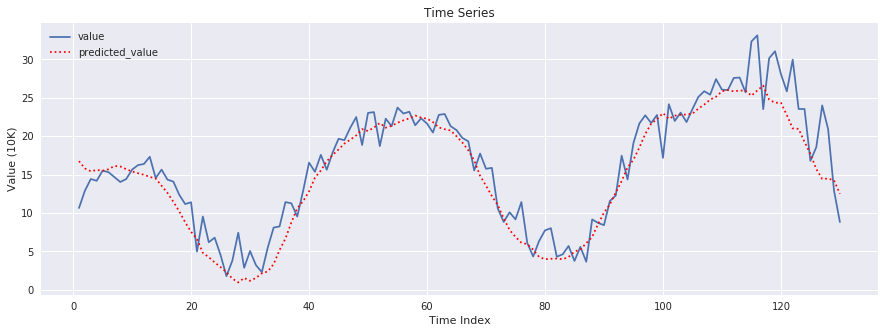

In [520]:
plt.close('all')
plt.figure(figsize=(15, 5))

plt.subplot(1,1,1)
plt.title("Time Series")
plt.plot(results2.time_index, results2.value)
plt.plot(results2.time_index, results2.predicted_value, ':r')
plt.xlabel("Time Index")
plt.ylabel("Value (10K)")
plt.legend()

## Implement the learnt model formula to use it for online forecasting 

### 1. Extract the model weights

In [418]:
def get_model_weights():
  
  import pandas as pd

  model_weights_query = """
  SELECT
    processed_input AS input,
    model.weight AS input_weight
  FROM
    ml.WEIGHTS(MODEL bqml_ts.extended_model) AS model
  """
  model_weights = pd.read_gbq(model_weights_query,
                       project_id=PROJECT,
                       dialect='standard',
                       private_key=None)
  
  return model_weights

get_model_weights()

Requesting query... ok.
Job ID: 4cbf3746-a2dc-4cbc-8096-77a0694f95ad
Query running...
Query done.
Processed: 96.0 B Billed: 10.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 12 rows.

Total time taken 1.81 s.
Finished at 2018-09-21 00:15:58.


,input,input_weight
0,time_index,0.860312
1,prev_value_1,1.443741
2,prev_value_2,1.258712
3,prev_value_3,0.834876
4,prev_value_4,0.859469
5,prev_value_5,0.628530
6,freq_cos_1,-3.390261
7,freq_cos_2,-0.833724
8,freq_cos_3,0.259685
9,freq_cos_4,0.137074


### 2. Extract the model scaling statistics

In [451]:
def get_scaling_stats():
  
  import pandas as pd

  scaling_stats_query = """
    SELECT
      input, min, max, mean, stddev
    FROM
      ml.FEATURE_INFO(MODEL bqml_ts.extended_model) AS model
  """
  scaling_stats = pd.read_gbq(scaling_stats_query,
                       project_id=PROJECT,
                       dialect='standard',
                       private_key=None)
  
  return scaling_stats

get_scaling_stats()

Requesting query... ok.
Job ID: ecff831b-6f57-4b82-9db0-7f7d986f2abf
Query running...
Query done.
Processed: 0.0 B Billed: 0.0 B
Standard price: $0.00 USD

Retrieving results...
Got 11 rows.

Total time taken 2.13 s.
Finished at 2018-09-21 00:48:50.


,input,min,max,mean,stddev
0,time_index,1.000000,130.0000,6.550000e+01,37.671829
1,prev_value_1,1.783600,33.1327,1.624110e+01,7.612502
2,prev_value_2,1.783600,33.1327,1.626698e+01,7.636714
3,prev_value_3,1.783600,33.1327,1.623029e+01,7.655624
4,prev_value_4,1.783600,33.1327,1.616853e+01,7.654357
5,prev_value_5,1.783600,33.1327,1.614919e+01,7.682069
6,freq_cos_1,-1.000000,1.0000,7.691127e-03,0.709800
7,freq_cos_2,-1.000000,1.0000,-8.405505e-07,0.709842
8,freq_cos_3,-1.000000,1.0000,7.691138e-03,0.709800
9,freq_cos_4,-0.970946,1.0000,-8.281598e-07,0.709842


### 3. Implement the fourier transformations

In [440]:
def compute_fourier(week_number):
 
  import math
  
  fourier_trans = {}
  
  fourier_trans['freq_cos_1'] = math.cos(week_number * 2* 3.14159 * 1/52)
  fourier_trans['freq_cos_2'] = math.cos(week_number * 2* 3.14159 * 2/52)
  fourier_trans['freq_cos_3'] = math.cos(week_number * 2* 3.14159 * 3/52)
  fourier_trans['freq_cos_4'] = math.cos(week_number * 2* 3.14159 * 4/52)
  fourier_trans['freq_cos_5'] = math.cos(week_number * 2* 3.14159 * 5/52)

  return fourier_trans

compute_fourier(51)

{'freq_cos_1': 0.9927082466769089,
 'freq_cos_2': 0.9709393260406853,
 'freq_cos_3': 0.9350107052901085,
 'freq_cos_4': 0.8854463497046807,
 'freq_cos_5': 0.8229690813934987}

### 4. Implement the estimate method
The methods expect:
* The time_index for which the forecast is needed. 
* The 5 previous values (actual or forecasted) to the given time_index
* The model weights
* The week_number (in the year) of the given time_index, to compute the fourier transformations

In [521]:
def estimate(model_weights, time_index, week_number, prev_values):

  fourier_trans = compute_fourier(week_number)
  
  inputs = prev_values
  inputs['time_index'] = time_index
  inputs.update(fourier_trans)
  
  estimate = 0
  
  for column_name in model_weights['input'].unique():

    weight = model_weights[model_weights['input'] == column_name]['input_weight'].values[0]
    
    if column_name == '__INTERCEPT__':
      input_value = 1.0
    else:
      meanv = scaling_stats[ scaling_stats['input'] == column_name ]['mean'].values[0]
      stddev = scaling_stats[ scaling_stats['input'] == column_name ]['stddev'].values[0]
      scaled_input = (inputs[column_name] - meanv)/stddev
      input_value = scaled_input

    estimate +=  weight * input_value
    
  return round(estimate, 5)

### 5. Get the base inputs 
This is refering to the last 5 **known values** in the learning data, to be used for forecasting the** uknown value** of the next step.

In [421]:
def get_base_inputs(base_time_index):

  import pandas as pd

  base_inputs_query = """
  SELECT
    prev_value_1,
    prev_value_2,
    prev_value_3,
    prev_value_4,
    prev_value_5
  FROM bqml_ts.learn_data_engineered
  WHERE time_index = {} 
  ;
  """.format(base_time_index)
  
  base_inputs = pd.read_gbq(base_inputs_query,
                       project_id=PROJECT,
                       dialect='standard',
                       private_key=None)
  return base_inputs

get_base_inputs(129)

Requesting query... ok.
Job ID: 9bd5b005-fe80-4f7e-8975-04363c7e23a4
Query running...
Query done.
Processed: 6.0 KB Billed: 10.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 2.09 s.
Finished at 2018-09-21 00:16:01.


,prev_value_1,prev_value_2,prev_value_3,prev_value_4,prev_value_5
0,20.9266,24.0118,18.5858,16.7937,23.5463


In [457]:
BASE_TIME_INDEX = 130
BASE_YEAR = 2015
BASE_WEEK_NUMBER = 52
BASE_YEAR_WEEK_DESC = '2015-52'
  
model_weights = get_model_weights()
base_inputs = get_base_inputs(BASE_TIME_INDEX)
scaling_stats = get_scaling_stats()

Requesting query... ok.
Job ID: 9ecf6ae5-7ae4-4113-91bb-a006053a4810
Query running...
Query done.
Cache hit.

Retrieving results...
Got 12 rows.

Total time taken 1.32 s.
Finished at 2018-09-21 00:51:02.
Requesting query... ok.
Job ID: a6f7e1db-245f-4413-aada-40039dcf3aa2
Query running...
Query done.
Processed: 6.0 KB Billed: 10.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 2.08 s.
Finished at 2018-09-21 00:51:05.
Requesting query... ok.
Job ID: 389cd840-6d0b-4d35-a373-5c044acb08e5
Query running...
Query done.
Cache hit.

Retrieving results...
Got 11 rows.

Total time taken 1.29 s.
Finished at 2018-09-21 00:51:07.


### 6. Forecast
In each step, 
* The output of the estimate method will be the prev_value1 for the following estimate step. 
* All the other prev_value(s) will be shifted. That is prev_value4 -> prev_value5, prev_value3 -> prev_value4, etc. 

In [522]:
def forecast(steps=10):
  
  print 'model weights:'
  print model_weights
  print ''
  
  print 'Forecasting {} steps'.format(steps)
  print 'Base time index: {}'.format(BASE_TIME_INDEX)
  print ''
  
  current_prev_values = base_inputs.copy()
  
  forecasts = pd.DataFrame(columns=['time_index','year_week_desc','forecast_value'])
  
  current_week_number = BASE_WEEK_NUMBER
  current_year = BASE_YEAR
  
  for step in range(1, steps + 1):
    
    current_time_index = BASE_TIME_INDEX + step
    
    if current_week_number == 52:
      current_week_number = 0
      current_year +=1
    
    current_week_number +=1

    current_value = estimate(model_weights, current_time_index, current_week_number, 
                             current_prev_values.to_dict(orient='records')[0])

    current_year_week_desc = '{}-{}'.format(current_year, current_week_number)
    
    current_forecast = {
      'time_index': current_time_index,
      'year_week_desc': current_year_week_desc,
      'forecast_value': current_value
    }
    
#     print current_forecast
#     print ''
    
    forecasts = forecasts.append(current_forecast, ignore_index=True)
    
    # shifting the previous values
    for i in range(len(df.columns)-1, 0, -1):
      current_prev_values.loc[0][i] = current_prev_values.loc[0][i-1]
    
    # adding the current forecasting value to be the previous value for the following step
    current_prev_values.loc[0][0] = current_value
    
  print '{} forecasts where produced'.format(len(forecasts))
    
  return forecasts

In [481]:
forecasts = forecast(steps=52)
forecasts.head(5)

model weights:
            input  input_weight
0      time_index      0.860312
1    prev_value_1      1.443741
2    prev_value_2      1.258712
3    prev_value_3      0.834876
4    prev_value_4      0.859469
5    prev_value_5      0.628530
6      freq_cos_1     -3.390261
7      freq_cos_2     -0.833724
8      freq_cos_3      0.259685
9      freq_cos_4      0.137074
10     freq_cos_5      0.119882
11  __INTERCEPT__     14.909911

Forecasting 52 steps
Base time index: 130

52 forecast where produced


,time_index,year_week_desc,forecast_value
0,131,2016-1,12.52097
1,132,2016-2,11.56342
2,133,2016-3,10.60468
3,134,2016-4,9.23790
4,135,2016-5,8.33908


### 7. Plot the actual vs. predicted for training, evaluation, test data

In [527]:
%sql --module query3 

SELECT
  time_index,
  value AS test_value
FROM
  bqml_ts.trips_data
WHERE
  time_index > 130
ORDER BY
  time_index ASC

In [528]:
test_data = bq.Query(query3).to_dataframe(dialect='standard')
test_data.tail(5)

,time_index,test_value
21,152,30.8270
22,153,31.5842
23,154,34.8903
24,155,35.7222
25,156,24.9333


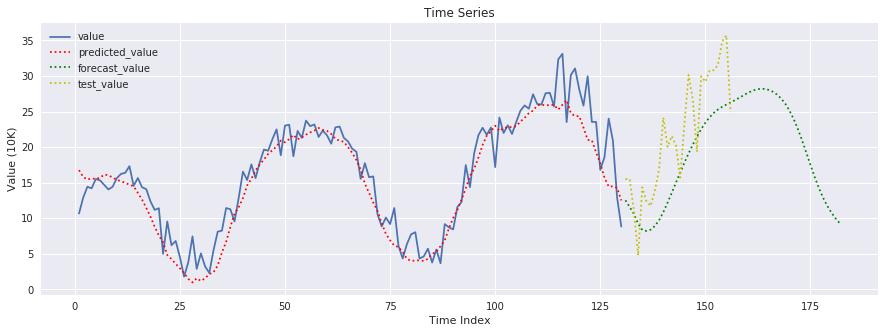

In [529]:
plt.close('all')
plt.figure(figsize=(15, 5))

plt.subplot(1,1,1)
plt.title("Time Series")
plt.plot(results2.time_index, results2.value)
plt.plot(results2.time_index, results2.predicted_value, ':r')
plt.plot(forecasts.time_index, forecasts.forecast_value, ':g')
plt.plot(test_data.time_index, test_data.test_value, ':y')
plt.xlabel("Time Index")
plt.ylabel("Value (10K)")
plt.legend()

In [532]:
squared_error = [math.pow(value, 2) 
                 for value in test_actual_pred['forecast_value'].values - test_actual_pred['test_value'].values]

mean_squared_error = sum(squared_error) / len(squared_error)

print 'Root Mean Squared Error: {}'.format(math.sqrt(mean_squared_error))

Root Mean Squared Error: 6.507480816


### Result: RMSE for the extended linear regression = 6.51 